# 词性标注POS标签及单词分组1

机器学习中很多时候都要跟自然语言文本打交道，而自然语言文本是unstructured dat，并且经常会有很多的"噪音"，所以尽可能从文本中提取出关键信息是提升模型质量的一个关键。这里介绍一种基于POS(Part-of-Speech)标签和单词分组的提取方法，可以有效的从文本中提取出关键信息。

## POS tagging

POS(part-of-speech)又名词性标注，它会根据上下文对单词打上词性标签。 英文中单词主要有8种词性—名词nouns, 动词verbs, 形容词adjectives, 代词pronouns, 副词adverbs, 连词conjunctions, 介词prepositions和感叹词interjections. 

NLTK中提供了POS标签功能，它是一种有监督的机器学习算法，根据前后词，首字母是否大写等语境情况来判断词性。 POS需要在完成分词(word tokenization)后进行， NLTK库中都提供了分词功能，NLTK中也提供了不同标签的说明文档

In [23]:
import nltk
from IPython.display import display

In [2]:
tokens = nltk.word_tokenize("The sailor dogs the hatch")
tokens

['The', 'sailor', 'dogs', 'the', 'hatch']

In [3]:
print(nltk.tag.pos_tag(tokens))

[('The', 'DT'), ('sailor', 'NN'), ('dogs', 'VBZ'), ('the', 'DT'), ('hatch', 'NN')]


dog在一般情况下都是名词，但在上面的例子中却是动词，这时就体现出机器学习方法的优势了，可以更为准确的区分出不同语境情况下的单词词性了。

In [4]:
nltk.help.upenn_tagset("VBZ")

VBZ: verb, present tense, 3rd person singular
    bases reconstructs marks mixes displeases seals carps weaves snatches
    slumps stretches authorizes smolders pictures emerges stockpiles
    seduces fizzes uses bolsters slaps speaks pleads ...


In [5]:
nltk.help.upenn_tagset("NN")

NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...


In [6]:
nltk.help.upenn_tagset("JJ")

JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...


## Chunking
Chunking就是从非结构下的文本中提取出词组，把文本分成一个个小的块。比如"brown fox"，与其把"brown"和"fox"分成两个单词，"brow fox"这个词组包含更为重要的信息，最好是把它们放在一起， 这时可以基于POS标签来做Chunking， NLTK中提供了一种基于正则表达式的Chunking方法。

如果想提取出文本中包含名词的词组，可以设计一个正则表达式，它包含0或1个限定词DT，0个或多个形空词JJ以及一个名词NN。下面来看实现细节

In [63]:
sent = "the little yellow dog barked at the cat"
tokens = nltk.word_tokenize(sent)
#Define your grammar using regular expressions
grammar = ('''
    NP: {<DT>?<JJ>*<NN>} # Noun Phrases
    ''')

cp = nltk.RegexpParser(grammar)

In [64]:
def extract_np(psent):
  for subtree in psent.subtrees():
    if subtree.label() == 'NP':
      yield ' '.join(word for word, tag in subtree.leaves())

In [65]:
ptokens =nltk.tag.pos_tag(tokens)
psent = cp.parse(ptokens)
print(ptokens)

[('the', 'DT'), ('little', 'JJ'), ('yellow', 'JJ'), ('dog', 'NN'), ('barked', 'VBD'), ('at', 'IN'), ('the', 'DT'), ('cat', 'NN')]


In [66]:
[npstr for npstr in extract_np(psent)]

['the little yellow dog', 'the cat']

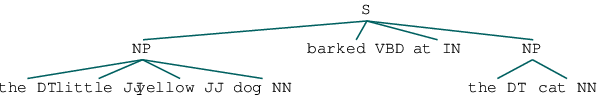

In [67]:
display(psent)

这个正则表达式提取出了"the little yellow dog"和"the cat"两个词组。表达式可以有多种组合，主要是要使用好正则表达符，最常用的是下面这些正则符号，更多的可以参考Python的[说明文档](https://docs.python.org/3/library/re.html)

|         |            | 
| ------------- |:-------------:| 
| \*  | 0或多次重复前面的RE(A regular expression) |
| ?   | 0或1次重复前面的RE |
| +	  | 1或多次重复前面的RE |


## Chinking

Chink用来表示不希望包含在chunk中的tokens， NLTK提供的RegexpParser接受的正则表达式中，
    { … } 表示chunk的模式
    } … { 表示chink的模式

In [68]:
grammar = ('''
    NP: {<.*>+}      # Chunk everything
    }<VBD|IN>+{      # Chink sequences of VBD and IN
    ''')

cp = nltk.RegexpParser(grammar)

In [69]:
psent = cp.parse(ptokens)
[npstr for npstr in extract_np(psent)]

['the little yellow dog', 'the cat']

## Splitter and Merger
除了Chunking和Chinking，还可以根据tag来进行拆分和合并操作。注意在RegexParser中，条款是顺序执行的，下一个条款的输入是上一个的输出。可以使用<.*>来输入整句或者先做完chunking和chinking后再输入到splitter和merger中

In [98]:
grammar = ('''
    NP:
        {<.*>+}                 # Chunk everything
        }<VBD|IN>+{             # Chink sequences of VBD and IN
        <JJ|DT>}{<NN.*>         # split a chunk at a determiner

      ''')
cp = nltk.RegexpParser(grammar)

In [99]:
psent = cp.parse(ptokens)
[npstr for npstr in extract_np(psent)]

['the little yellow', 'dog', 'the', 'cat']

In [100]:
grammar = ('''
    NP:
        {<.*>+}      # Chunk everything
        }<VBD|IN>+{      # Chink sequences of VBD and IN
        <JJ|DT>}{<NN.*>         # split a chunk at a determiner
        <DT|JJ>{}<NN.*>    # merge chunk ending with det/adj
      ''')
cp = nltk.RegexpParser(grammar)

In [101]:
psent = cp.parse(ptokens)
[npstr for npstr in extract_np(psent)]

['the little yellow dog', 'the cat']

In [102]:
grammar = ('''
    NP:
        {<.*>+}             # Chunk everything
        }<VBD|IN|DT>+{      # Chink sequences of VBD, DT and IN
        {<JJ>*<NN>}         # Chunk JJ NN phrases
      ''')
cp = nltk.RegexpParser(grammar)

In [103]:
psent = cp.parse(ptokens)
[npstr for npstr in extract_np(psent)]

['little yellow dog', 'cat']